In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Prepare for Dataset

In [41]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(trainset.data.shape)
print(testset.data.shape)
print(len(trainset.data))

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)
50000


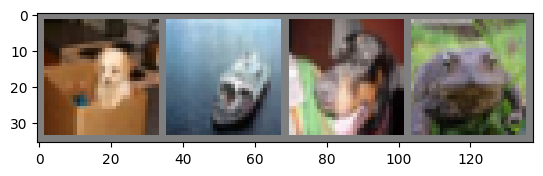

torch.Size([4, 3, 32, 32])
  dog  ship   dog  frog


In [42]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
# images, labels = dataiter.next()
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))

print(images.size())
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Choose a Device

In [43]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(device)  
# If 'mps or cuda:0' is printed, it means GPU is available.

mps


#### Network Definition

In [44]:
class AvgNet(nn.Module):
    def __init__(self):
        super(AvgNet, self).__init__()
        
        # input image shape = 3x32x32
        # 3 input image channels, 10 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        
        # input image shape = 10x16x16
        # 10 input image channels, 20 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        
        # input image shape = 20x8x8
        # affine operation to hidden layer with 100 neurons
        self.fc1 = nn.Linear(20 * 8 * 8, 100)
        
        # affine operation to output layer with 10 neurons
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
       
        # conv1 then relu then max pool
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, (2, 2))
        
        # conv2 relu max pool
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, (2, 2))
        
        # flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

avg_net = AvgNet()     # Create the network instance.
avg_net.to(device)  # Move the network parameters to the specified device.

AvgNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

#### Optimizer and Loss Function

In [45]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(avg_net.parameters(), lr=0.001, momentum=0.9)

#### Training Procedure

In [46]:
avg_train_losses = []   # Avg. losses.
train_accuracies, test_accuracies = [], []  # Train and test accuracies.

epochs = 10       # Total epochs.

iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    train_running_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = avg_net(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # record statistics.
        train_running_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Record both training and testing loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = train_running_loss / record_freq
            avg_train_losses.append(avg_train_loss)
            train_running_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
                
    # Set the model to evaluation mode.
    avg_net.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = avg_net(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    
    # Set the model back to training mode.
    avg_net.train()     

            
print('Finished Training.')

# save model
PATH = './cifar_avg_net_sgd.pth'
torch.save(avg_net.state_dict(), PATH)  

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.897
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.660
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.588
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.533
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.432
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.399
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.391
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.248
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.212
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 1.245
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 1.073
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 1.188
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 1.230
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 1.220
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 1.070
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

#### Training Loss Curve

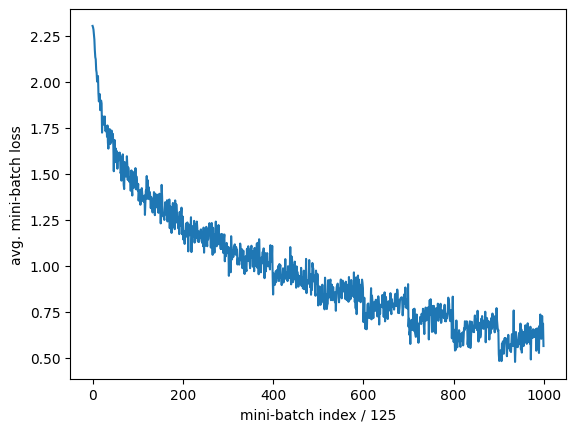

In [47]:
plt.plot(avg_train_losses)
plt.xlabel('mini-batch index / {}'.format(record_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

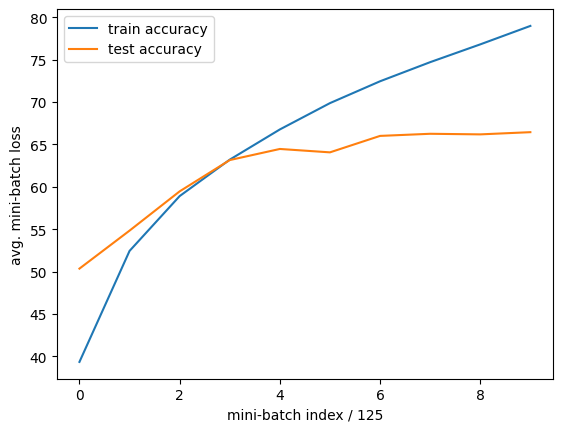

In [48]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.xlabel('mini-batch index / {}'.format(record_freq))
plt.ylabel('avg. mini-batch loss')
plt.legend(['train accuracy', 'test accuracy'])
plt.show()

#### Evaluate on Test Dataset

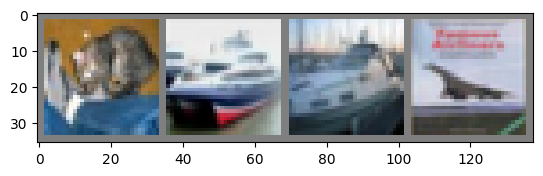

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane


In [49]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = avg_net(images.to(device))

# max compare along the row, return the index of the max value, which is the predicted class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [93]:
avg_net.eval()
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = avg_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64.42 %


In [51]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = avg_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 78 %
Accuracy of  bird : 63 %
Accuracy of   cat : 43 %
Accuracy of  deer : 59 %
Accuracy of   dog : 51 %
Accuracy of  frog : 73 %
Accuracy of horse : 68 %
Accuracy of  ship : 77 %
Accuracy of truck : 74 %


### Extra Credit - Improve Accuracy

#### Average Pooling + Batch Normalization

In [64]:
class AvgBNNet(nn.Module):
    def __init__(self):
        super(AvgBNNet, self).__init__()
        
        # input image shape = 3x32x32
        # 3 input image channels, 10 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        
        # input image shape = 10x16x16
        # 10 input image channels, 20 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(20)
        
        # input image shape = 20x8x8
        # affine operation to hidden layer with 100 neurons
        self.fc1 = nn.Linear(20 * 8 * 8, 100)
        
        self.bn3 = nn.BatchNorm1d(100)
        # affine operation to output layer with 10 neurons
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
       
        # conv1 then relu then max pool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, (2, 2))
        
        # conv2 relu max pool
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, (2, 2))
        
        # flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

avg_bn_net = AvgBNNet()     # Create the network instance.
avg_bn_net.to(device)  # Move the network parameters to the specified device.

AvgBNNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

#### Average Pooling + Dropout

In [147]:
class AvgDropNet(nn.Module):
    def __init__(self):
        super(AvgDropNet, self).__init__()
        
        # input image shape = 3x32x32
        # 3 input image channels, 10 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        
        # input image shape = 10x16x16
        # 10 input image channels, 20 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        
        
        # dropout layer before fully connected layer 1
        self.dp1 = nn.Dropout(p=0.5)        
                
        # input image shape = 20x8x8
        # affine operation to hidden layer with 100 neurons
        self.fc1 = nn.Linear(20 * 8 * 8, 100)
        
        # dropout layer before fully connected layer 2
        self.dp2 = nn.Dropout(p=0.5)
        
        # affine operation to output layer with 10 neurons
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
       
        # conv1 then relu then max pool
        x = self.conv1(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, (2, 2))
        
        # conv2 relu max pool
        x = self.conv2(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, (2, 2))
        
        # flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = self.dp1(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        
        return x

avg_drop_net = AvgDropNet()     # Create the network instance.
avg_drop_net.to(device)  # Move the network parameters to the specified device.

AvgDropNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dp1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (dp2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

Max Pooling

In [148]:
class MaxNet(nn.Module):
    def __init__(self):
        super(MaxNet, self).__init__()
        
        # input image shape = 3x32x32
        # 3 input image channels, 10 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        
        # input image shape = 10x16x16
        # 10 input image channels, 20 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        
        # input image shape = 20x8x8
        # affine operation to hidden layer with 100 neurons
        self.fc1 = nn.Linear(20 * 8 * 8, 100)
        
        # affine operation to output layer with 10 neurons
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
       
        # conv1 then relu then max pool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        
        # conv2 relu max pool
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        
        # flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

max_net = MaxNet()     # Create the network instance.
max_net.to(device)  # Move the network parameters to the specified device.

MaxNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

Max Pooling + Batch Normalization

In [68]:
class MaxBNNet(nn.Module):
    def __init__(self):
        super(MaxBNNet, self).__init__()
        
        # input image shape = 3x32x32
        # 3 input image channels, 10 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        
        # input image shape = 10x16x16
        # 10 input image channels, 20 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(20)
        
        # input image shape = 20x8x8
        # affine operation to hidden layer with 100 neurons
        self.fc1 = nn.Linear(20 * 8 * 8, 100)
        self.bn3 = nn.BatchNorm1d(100)
        
        # affine operation to output layer with 10 neurons
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
       
        # conv1 then relu then max pool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        
        # conv2 relu max pool
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        
        # flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

max_bn_net = MaxBNNet()     # Create the network instance.
max_bn_net.to(device)  # Move the network parameters to the specified device.

MaxBNNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

Max Pooling + Dropout

In [149]:
class MaxDropNet(nn.Module):
    def __init__(self):
        super(MaxDropNet, self).__init__()
        
        # input image shape = 3x32x32
        # 3 input image channels, 10 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        
        # input image shape = 10x16x16
        # 10 input image channels, 20 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        
        self.dp1 = nn.Dropout(p=0.5)
        # input image shape = 20x8x8
        # affine operation to hidden layer with 100 neurons
        self.fc1 = nn.Linear(20 * 8 * 8, 100)

        self.dp2 = nn.Dropout(p=0.5)
        # affine operation to output layer with 10 neurons
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
       
        # conv1 then relu then max pool
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        
        # conv2 relu max pool
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        
        # flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = self.dp1(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        
        return x

max_drop_net = MaxDropNet()     # Create the network instance.
max_drop_net.to(device)  # Move the network parameters to the specified device.

MaxDropNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dp1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (dp2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

#### Use Adam for 6 different models: avg pooling, max pooling, avg pooling with dropout, max pooling with dropout, avg pooling with batch normalization, max pooling with batch normalization

In [57]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(avg_net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

avg_avg_train_losses = []   # Avg. losses.
avg_train_accuracies, avg_test_accuracies = [], []  # Train and test accuracies.

epochs = 10             # Total epochs.

iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = avg_net(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        
        # Record training loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            avg_avg_train_losses.append(avg_train_loss)
            running_train_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
        
    # Set the model to evaluation mode.
    avg_net.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    avg_train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = avg_net(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    avg_test_accuracies.append(test_accuracy)
    # Set the model back to training mode.
    avg_net.train()     
              

print('Finished Training.')
PATH = './cifar_avg_net_adam.pth'
torch.save(avg_net.state_dict(), PATH)

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 0.863
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 0.847
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 0.896
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 0.854
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 0.881
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 0.729
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 0.833
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 0.796
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 0.765
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 0.766
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 0.507
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 0.666
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 0.699
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 0.620
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 0.669
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

In [70]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(avg_bn_net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

avg_bn_avg_train_losses = []   # Avg. losses.
avg_bn_train_accuracies, avg_bn_test_accuracies = [], []  # Train and test accuracies.

epochs = 10             # Total epochs.

iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = avg_bn_net(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        
        # Record training loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            avg_bn_avg_train_losses.append(avg_train_loss)
            running_train_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
        
    # Set the model to evaluation mode.
    avg_bn_net.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    avg_bn_train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = avg_bn_net(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    avg_bn_test_accuracies.append(test_accuracy)
    # Set the model back to training mode.
    avg_bn_net.train()     
              

print('Finished Training.')
PATH = './cifar_avg_bn_net_adam.pth'
torch.save(avg_bn_net.state_dict(), PATH)

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.703
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.591
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.644
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.569
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.463
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.446
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.479
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.462
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.340
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 1.360
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 1.307
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 1.328
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 1.319
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 1.352
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 1.364
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

In [150]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(avg_drop_net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

avg_drop_avg_train_losses = []   # Avg. losses.
avg_drop_train_accuracies, avg_drop_test_accuracies = [], []  # Train and test accuracies.

epochs = 10             # Total epochs.

iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = avg_drop_net(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        
        # Record training loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            avg_drop_avg_train_losses.append(avg_train_loss)
            running_train_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
        
    # Set the model to evaluation mode.
    avg_drop_net.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    avg_drop_train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = avg_drop_net(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    avg_drop_test_accuracies.append(test_accuracy)
    # Set the model back to training mode.
    avg_drop_net.train()     
              

print('Finished Training.')
PATH = './cifar_avg_drop_net_adam.pth'
torch.save(avg_drop_net.state_dict(), PATH)

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.751
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.728
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.588
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.536
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.453
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.467
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.393
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.488
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.511
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 1.414
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 1.359
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 1.445
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 1.484
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 1.324
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 1.440
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

In [151]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(max_net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

max_avg_train_losses = []   # Avg. losses.
max_train_accuracies, max_test_accuracies = [], []  # Train and test accuracies.

epochs = 10             # Total epochs.

iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = max_net(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        
        # Record training loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            max_avg_train_losses.append(avg_train_loss)
            running_train_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
        
    # Set the model to evaluation mode.
    max_net.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    max_train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = max_net(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    max_test_accuracies.append(test_accuracy)
    # Set the model back to training mode.
    max_net.train()     
              

print('Finished Training.')
PATH = './cifar_max_net_adam.pth'
torch.save(max_net.state_dict(), PATH)

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.535
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.383
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.318
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.216
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.020
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.031
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.089
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.024
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.100
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 0.962
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 0.856
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 0.904
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 0.903
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 0.905
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 0.839
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

In [73]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(max_bn_net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

max_bn_avg_train_losses = []   # Avg. losses.
max_bn_train_accuracies, max_bn_test_accuracies = [], []  # Train and test accuracies.

epochs = 10             # Total epochs.

iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = max_bn_net(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        
        # Record training loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            max_bn_avg_train_losses.append(avg_train_loss)
            running_train_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
        
    # Set the model to evaluation mode.
    max_bn_net.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    max_bn_train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = max_bn_net(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    max_bn_test_accuracies.append(test_accuracy)
    # Set the model back to training mode.
    max_bn_net.train()     
              

print('Finished Training.')
PATH = './cifar_max_bn_net_adam.pth'
torch.save(max_bn_net.state_dict(), PATH)

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.700
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.493
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.527
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.554
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.442
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.550
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.358
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.346
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.414
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 1.410
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 1.218
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 1.441
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 1.344
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 1.254
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 1.339
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

In [152]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(max_drop_net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

max_drop_avg_train_losses = []   # Avg. losses.
max_drop_train_accuracies, max_drop_test_accuracies = [], []  # Train and test accuracies.

epochs = 10             # Total epochs.

iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = max_drop_net(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        
        # Record training loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            max_drop_avg_train_losses.append(avg_train_loss)
            running_train_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
        
    # Set the model to evaluation mode.
    max_drop_net.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    max_drop_train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = max_drop_net(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    max_drop_test_accuracies.append(test_accuracy)
    # Set the model back to training mode.
    max_drop_net.train()     
              

print('Finished Training.')
PATH = './cifar_max_drop_net_adam.pth'
torch.save(max_drop_net.state_dict(), PATH)

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.669
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.564
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.541
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.609
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.506
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.589
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.396
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.520
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.352
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 1.434
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 1.451
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 1.405
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 1.416
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 1.315
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 1.424
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

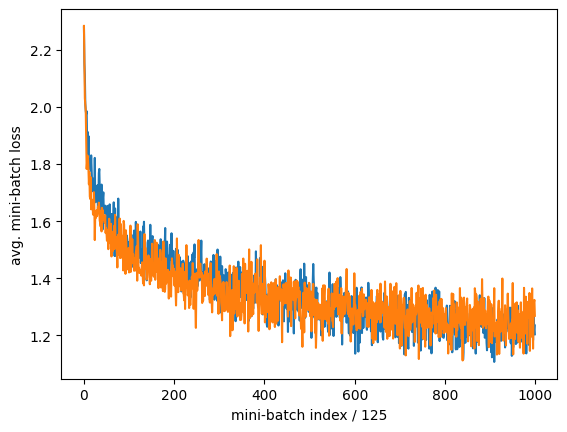

In [153]:
# plt.plot(avg_avg_train_losses)
# plt.plot(avg_bn_avg_train_losses)
plt.plot(avg_drop_avg_train_losses)
# plt.plot(max_avg_train_losses)
# plt.plot(max_bn_avg_train_losses)
plt.plot(max_drop_avg_train_losses)
plt.xlabel('mini-batch index / {}'.format(record_freq))
plt.ylabel('avg. mini-batch loss')
# plt.legend(['avg', 'avg_bn', 'avg_drop', 'max', 'max_bn', 'max_drop'])
plt.show()

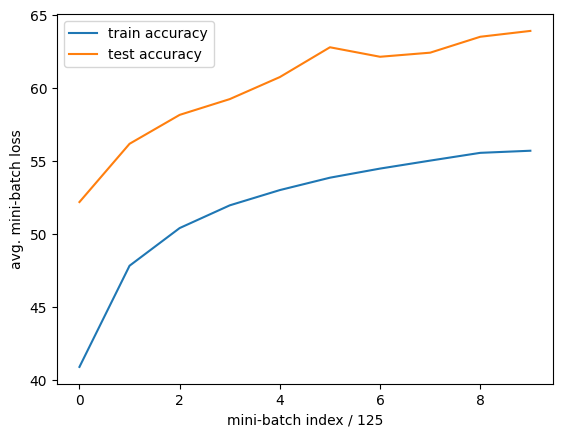

In [154]:
plt.plot(max_bn_train_accuracies)
plt.plot(max_bn_test_accuracies)
plt.xlabel('mini-batch index / {}'.format(record_freq))
plt.ylabel('avg. mini-batch loss')
plt.legend(['train accuracy', 'test accuracy'])
plt.show()

In [163]:
# put all models in a list
models = [avg_net, avg_bn_net, avg_drop_net, max_net, max_bn_net, max_drop_net]

# set all models to eval mode
for model in models:
    model.eval()

In [156]:
corrects = [0] * 6
totals = [0] * 6

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        for i, model in enumerate(iterable=models, start=0):
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            totals[i] += labels.size(0)
            corrects[i] += (predicted == labels).sum().item()

# print all the accuracies
for i in range(len(models)):
    print('Accuracy of the %s network on the 10000 test images: %.2f %%' % (models[i].__class__.__name__,
        100 * corrects[i] / totals[i]))

Accuracy of the AvgNet network on the 10000 test images: 64.42 %
Accuracy of the AvgBNNet network on the 10000 test images: 68.29 %
Accuracy of the AvgDropNet network on the 10000 test images: 64.94 %
Accuracy of the MaxNet network on the 10000 test images: 64.33 %
Accuracy of the MaxBNNet network on the 10000 test images: 69.33 %
Accuracy of the MaxDropNet network on the 10000 test images: 63.91 %


In [136]:
# load model explicitly
# max_net = MaxNet()
# max_net.to(device)
# PATH = './cifar_max_net_adam.pth'
# max_net.load_state_dict(torch.load(PATH))
# max_net.eval()

MaxNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [165]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = [model(images).data for model in models]
        enssembled_outputs = torch.stack(outputs, dim=0).sum(dim=0)
        _, predicted = torch.max(enssembled_outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
print('Accuracy of the essembled network on the 10000 test images: %.2f %%' % (
        100 * correct / total))

Accuracy of the essembled network on the 10000 test images: 73.70 %


In [124]:
# just a script to understand what .data does
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs1 = avg_bn_net(images)
print(outputs1)
print(outputs1.data)
_, predicted = torch.max(outputs1.data, 1)
print(labels)
print(predicted)
print(predicted == labels)
c = (predicted == labels).squeeze()
print(c)

tensor([[-3.4967, -4.9822, -4.5038,  0.0880, -3.8759, -1.4940, -3.0071, -4.3399,
         -0.2131, -4.1152],
        [ 0.0711,  3.4113, -3.8370, -3.7963, -5.6577, -5.9947, -8.0490, -2.8024,
          0.7028, -2.0797],
        [ 0.1010, -0.6433, -3.5087, -2.8251, -3.0741, -5.4893, -5.5182, -2.0182,
         -0.1710, -1.3593],
        [ 2.2307,  0.0133, -3.0063, -2.6697, -2.6974, -5.9213, -4.1817, -3.8934,
         -1.4629, -3.6291]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[-3.4967, -4.9822, -4.5038,  0.0880, -3.8759, -1.4940, -3.0071, -4.3399,
         -0.2131, -4.1152],
        [ 0.0711,  3.4113, -3.8370, -3.7963, -5.6577, -5.9947, -8.0490, -2.8024,
          0.7028, -2.0797],
        [ 0.1010, -0.6433, -3.5087, -2.8251, -3.0741, -5.4893, -5.5182, -2.0182,
         -0.1710, -1.3593],
        [ 2.2307,  0.0133, -3.0063, -2.6697, -2.6974, -5.9213, -4.1817, -3.8934,
         -1.4629, -3.6291]], device='mps:0')
tensor([3, 8, 8, 0], device='mps:0')
tensor([3, 1, 0, 0], device='m

In [162]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = [model(images).data for model in models]
        enssembled_outputs = torch.stack(outputs, dim=0).sum(dim=0)
        _, predicted = torch.max(enssembled_outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

KeyboardInterrupt: 

#### Description
##### Ran 6 different models with fixed learning rate 1e-3 and Adam optimizer with no weight decay (L2 Regularization) for gradient update.
Before doing any experiment, I gathered some information from the average pooling based model as described in Q5.

I first plot the training loss curve at a frequency of 100 times per epoch to understand the training process. Then I plot the accuracy comparison once per epoch (computing accuracy is expensive) to make more observations.

Judging from the training loss curve alone, the model converge nicely and the loss does not fluctuate too much toward the end of the training,

Observing the accuracy comparison chart from average pooling based model as described in Q5, we can see the gap between train accuracy and test accuracy start getting bigger in each epoch; more precisely, test accuracy does not increase in proportion to train accuracy. This is a clear sign of overfitting.

To address overfitting, some form of regularization is needed, therefore I decided to try out various techniques such as Batch Normalization and Dropout. I've also included max pooling because it's a more common practice than average pooling to extract features from the input.

For Batch Normalization before each ReLU layer for Gaussian distributed input

1. Average Pooling (same architecture as the write-up)
2. Average Pooling + 
3. 
4. 